### TODO
- Mutiplicar os valores por 1000 no resultado.
- (FICOU UMA BOSTA) agrupar o plot do sarima para deixar a visualização mais adequada
- Coletar resultados do sarima e do LSTM
- Executar o BiLSTM e ver o resultado, e coletar tambem (colocar em uma planilha)
- Carregar o modelo LSTM e BiLSTM e testar em outras estações

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Conv1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import tensorflow as tf

2025-05-26 08:44:54.598281: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 08:44:54.646779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 08:44:54.647852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 08:44:55.527161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%run UtilsNew.ipynb

### Load and filter data

In [3]:
raw_anual_df = pd.read_csv("data/minas_gerais_gv.csv", sep=";")
anual_df = pre_processing(raw_anual_df)

anual_df["hora"] = anual_df["data_hora"].dt.hour
anual_df = filter_between(anual_df, "hora", 7, 18)

### Data segmentation

In [4]:
train_size = int(0.7 * (round(len(anual_df)/10)*10))

train_df = anual_df.iloc[0:train_size]
test_df = anual_df.iloc[train_size:]

WINDOW_SIZE = 11

### Create input and output

In [5]:
def data_to_input_and_output(data):
    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['radiacao'][index:index + WINDOW_SIZE]
        output_sample = data['radiacao'][index + WINDOW_SIZE]
     
        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data)/1000, np.array(output_data)/1000
    # return normalize(np.array(input_data)), normalize([np.array(output_data)])[0]

In [6]:
train_input, train_output = data_to_input_and_output(train_df)
test_input, test_output = data_to_input_and_output(test_df)

### Funções

In [7]:
checkpoint_filepath = '/tmp/lstm/lstm_solar_model.h5'

def normalize_leo(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

def teste():
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    # normalize the dataset and print
    standardized = scaler.transform(values)

def train_solar_bi_lstm(X, y, epochs=100, learning_rate=0.001):

    checkpoint_filepath_bilstm = '/tmp/lstm/lstm_solar_model.h5'
    
    model = Sequential()
    model.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    check_point = ModelCheckpoint(filepath=checkpoint_filepath_bilstm, 
                                  save_best_only=True, 
                                  monitor='loss')

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[
            MeanSquaredError(), 
            RootMeanSquaredError(),
            MeanAbsoluteError(),
            
        ]
    )

    model.fit(X, y, epochs=epochs, callbacks=[check_point], verbose=0)

    return model

def train_solar_lstm(X, y, epochs=100, learning_rate=0.001):
    model = Sequential()
    model.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(64, return_sequences=True))  # Mantém a saída sequencial
    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    check_point = ModelCheckpoint(filepath=checkpoint_filepath, 
                                  save_best_only=True, 
                                  monitor='loss')

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[
            MeanSquaredError(), 
            RootMeanSquaredError(),
            MeanAbsoluteError()
        ]
    )

    model.fit(X, y, epochs=epochs, callbacks=[check_point], verbose=0)

    return model

def plot_results(df_orig, pred, real):
    set_plot_size(12, 6)
    
    period = df_orig[0:len(df_orig) - WINDOW_SIZE]['data']
    pred = pred.reshape(pred.shape[0])
    
    df_pred = pd.DataFrame(data=pred, index=period, columns=["predicted"])
    df_real = pd.DataFrame(data=real, index=period, columns=["real"])
    
    sns.lineplot(df_pred, palette=["red"], ci=None)
    sns.lineplot(df_real, palette=["blue"], ci=None)

## LSTM

### Training model

In [8]:
lstm_model = train_solar_lstm(train_input, train_output)

2025-05-26 08:44:59.089958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Predicting

In [9]:
# model = load_model(checkpoint_filepath)

In [10]:
train_pred = lstm_model.predict(train_input)
test_pred = lstm_model.predict(test_input)

39/39 [==============================] - 0s 3ms/step


### Plotting

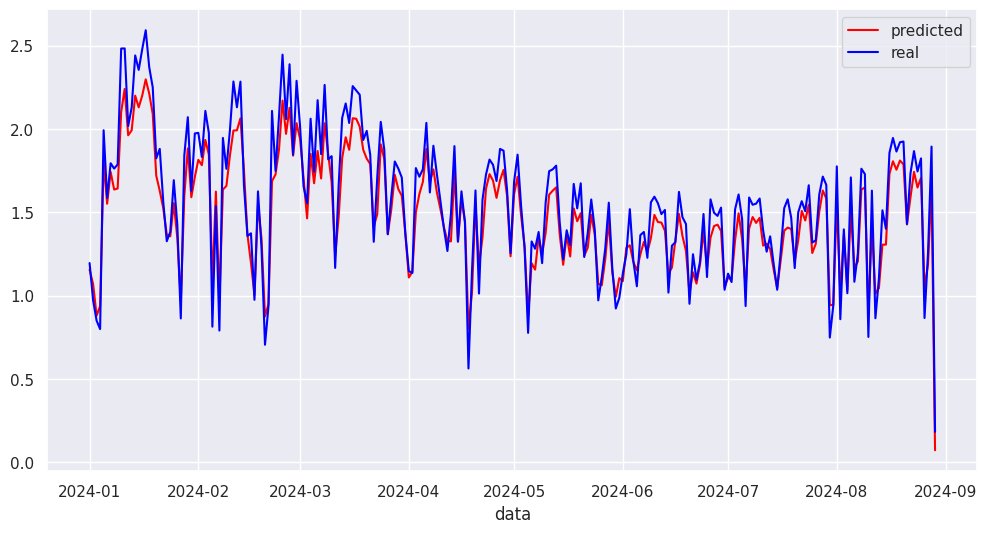

In [11]:
plot_results(train_df, train_pred, train_output)

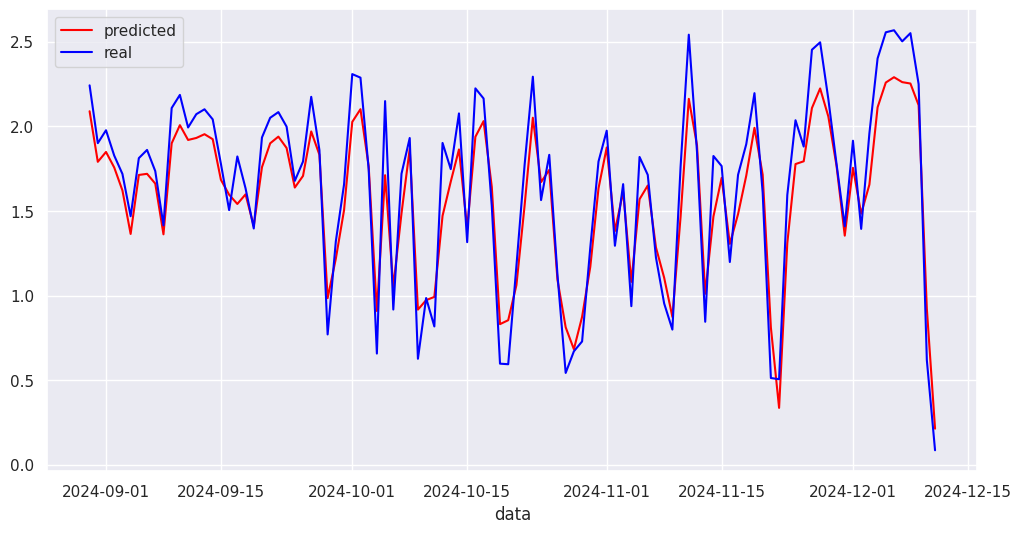

In [12]:
plot_results(test_df, test_pred, test_output)

### Metricas

In [13]:
metrics = lstm_model.get_metrics_result()
metrics["r2_score"] = r2_score(train_output, train_pred)

for i in metrics.keys():
    try:
        value = metrics[i]._summarize_value()
    except:
        value = metrics[i]
    print(i + ": " + str(value))

loss: 0.14445585
mean_squared_error: 0.144686192
root_mean_squared_error: 0.380073488
mean_absolute_error: 0.269722313
r2_score: 0.8720901755307314


## BiLSTM

### Training model

In [14]:
bilstm_model = train_solar_bi_lstm(train_input, train_output)

### Predicting

In [15]:
train_pred = bilstm_model.predict(train_input)
test_pred = bilstm_model.predict(test_input)

39/39 [==============================] - 0s 5ms/step


### Plotting

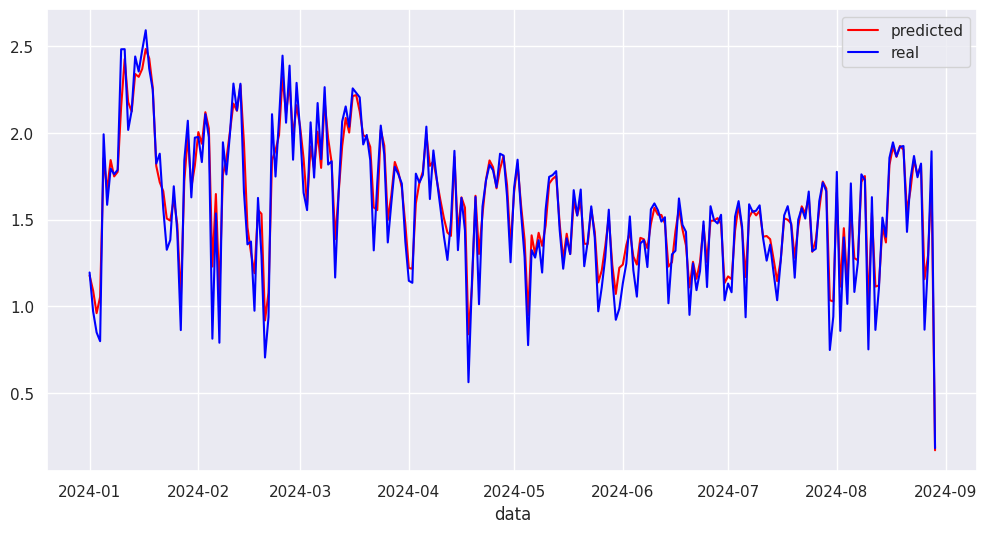

In [16]:
plot_results(train_df, train_pred, train_output)

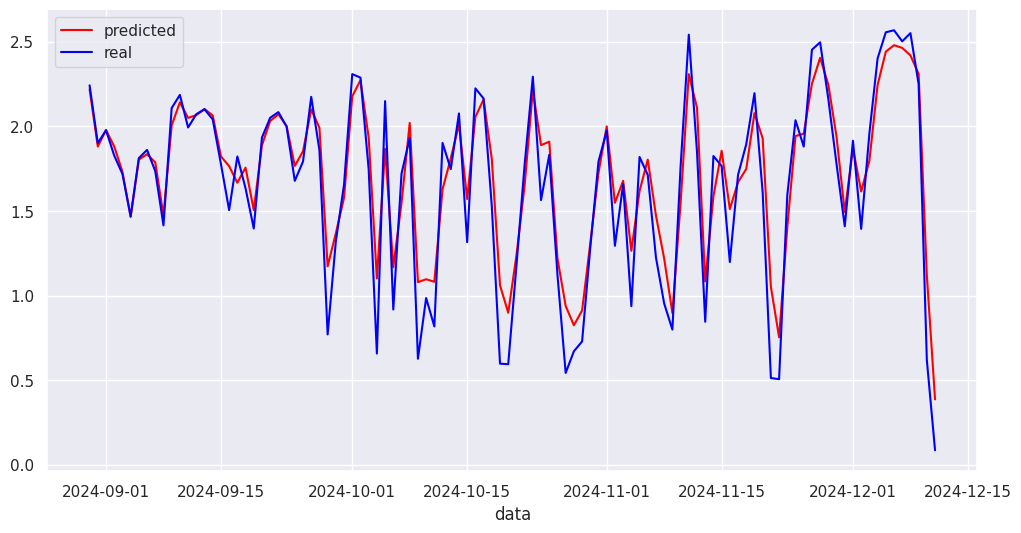

In [17]:
plot_results(test_df, test_pred, test_output)

### Metrics

In [18]:
metrics = bilstm_model.get_metrics_result()
metrics["r2_score"] = r2_score(train_output, train_pred)

for i in metrics.keys():
    try:
        value = metrics[i]._summarize_value()
    except:
        value = metrics[i]
    print(i + ": " + str(value))

loss: 0.134536341
mean_squared_error: 0.134378418
root_mean_squared_error: 0.366791964
mean_absolute_error: 0.256223798
r2_score: 0.8866868921857296
